In [1]:
from pyincore import IncoreClient

import numpy as np
import pandas as pd
import os

In [2]:
client = IncoreClient()  # The authentication service validates username/password and
                         # approves users to access to other services."https://incore-dev.ncsa.illinois.edu"
#client.clear_cache()

Connection successful to IN-CORE services. pyIncore version detected: 0.9.6


In [17]:
# create data_service object for loading files
data_service = DataService(client)

### Set IN-CORE Dataservice IDS

In [3]:
# Community Description Datasets
# Load the Joplin building dataset
bldg_dataset_id = "5dbc8478b9219c06dd242c0d" 
# Newton and Jasper County 2010 Housing Unit Inventory
housing_unit_inv_id = "5dfd1104fc33d500081556b6"
# Newton and Jasper County 2010 Address point inventory
address_point_inv_id = "5dbc6ba1b9219c06dd222bab"
# Newton and Jasper County Block Group Data
bg_data = "5d4c9545b9219c0689b2358a"

# Hazard Datasets
hazard_type = "tornado"
# Joplin 2011 Tornado Path
hazard_id = "5d07cbeab9219c065b080930" 
# Create a mapping to assign tornado fragilities to 19 building archetypes.
mapping_id = "5e4ca44f9e2c59000178984d"
# Bae et al 2009 Value Loss Beta Distributions by Damage Level
value_loss = "60354810e379f22e16560dbd"

## Set up Housing Unit Allocation Loop

In [4]:
hua_output_path = os.path.join(os.getcwd(), 'housingunitallocation')
if not os.path.exists(hua_output_path):
    os.makedirs(hua_output_path)

In [5]:
from pyincore.analyses.housingunitallocation import HousingUnitAllocation

# Create housing allocation 
hua = HousingUnitAllocation(client)

# Load static input dataset
hua.load_remote_input_dataset("housing_unit_inventory", housing_unit_inv_id)
hua.load_remote_input_dataset("address_point_inventory", address_point_inv_id)
hua.load_remote_input_dataset("buildings", bldg_dataset_id)

Dataset already exists locally. Reading from local cached zip.
Unzipped folder found in the local cache. Reading from it...
Dataset already exists locally. Reading from local cached zip.
Unzipped folder found in the local cache. Reading from it...
Dataset already exists locally. Reading from local cached zip.
Unzipped folder found in the local cache. Reading from it...


#### Save Housing Unit Inventory as Dataframe for Output of loop
The loop will produce population impact results by housing unit id - the resutls will be added to the housing unit inventory.

In [18]:
# load housing unit inventory as pandas dataframe
housing_unit_inv = Dataset.from_data_service(housing_unit_inv_id, data_service)
filename = housing_unit_inv.get_file_path('csv')
print("The IN-CORE Dataservice has saved the Housing Unit Inventory on your local machine: "+filename)

housing_unit_inv_df = pd.read_csv(filename, header="infer")
housing_unit_inv_df.head()

Dataset already exists locally. Reading from local cached zip.
Unzipped folder found in the local cache. Reading from it...
The IN-CORE Dataservice has saved the Housing Unit Inventory on your local machine: C:\Users\nathanael99\.incore\cache_data\5dfd1104fc33d500081556b6\IN-CORE_2ev3_SetupJoplin_FourInventories_2019-08-06_HUinventory\IN-CORE_2ev3_SetupJoplin_FourInventories_2019-08-06_HUinventory.csv


,huid,blockid,tractid,bgid,FIPScounty,serialno,livetype,numprec,gqpop,ownershp,race,hispan,hispan_flag,vacancy,gqtype,hhinc
0,B290970101001000H001,290970101001000,29097010100,290970101001,29097,1,H,3,0,1.0,1.0,0.0,1.0,0,0,3.0
1,B290970101001000H002,290970101001000,29097010100,290970101001,29097,2,H,1,0,2.0,1.0,0.0,1.0,0,0,2.0
2,B290970101001000H003,290970101001000,29097010100,290970101001,29097,3,H,1,0,1.0,1.0,0.0,1.0,0,0,3.0
3,B290970101001001H001,290970101001001,29097010100,290970101001,29097,1,H,1,0,1.0,1.0,0.0,1.0,0,0,2.0
4,B290970101001002H001,290970101001002,29097010100,290970101001,29097,1,H,6,0,2.0,1.0,0.0,1.0,0,0,3.0


## Set up Building Damage Loop

In [6]:
bldg_damage_output_path = os.path.join(os.getcwd(), 'building damage')
if not os.path.exists(bldg_damage_output_path):
    os.makedirs(bldg_damage_output_path)

In [7]:
from pyincore import FragilityService, MappingSet, Dataset, DataService
from pyincore.models.fragilitycurveset import FragilityCurveSet
from pyincore.analyses.buildingdamage import BuildingDamage

fragility_service = FragilityService(client)  # loading fragility mapping
mapping_set = MappingSet(fragility_service.get_mapping(mapping_id))

# Create building damage analysis
bldg_dmg = BuildingDamage(client)

building_inv = bldg_dmg.load_remote_input_dataset("buildings", bldg_dataset_id)
bldg_dmg.set_input_dataset("dfr3_mapping_set", mapping_set)

# Load static analysis input datasets
bldg_dmg.set_parameter("hazard_type", hazard_type)
bldg_dmg.set_parameter("hazard_id", hazard_id)
bldg_dmg.set_parameter("num_cpu", 4)  # Define the result name, etc., and choose the number of CPU locally
                                # to run the model parallelly.

Dataset already exists locally. Reading from local cached zip.
Unzipped folder found in the local cache. Reading from it...


True

## Set up Population Dislocation Loop

In [8]:
popdis_output_path = os.path.join(os.getcwd(), 'population dislocation')
if not os.path.exists(popdis_output_path):
    os.makedirs(popdis_output_path)

In [9]:
from pyincore.analyses.populationdislocation import PopulationDislocation, PopulationDislocationUtil

# Create Population dislocation analysis
pop_dis = PopulationDislocation(client)

# Load static analysis input datasets
pop_dis.load_remote_input_dataset("block_group_data", bg_data)
pop_dis.load_remote_input_dataset("value_poss_param", value_loss)

Dataset already exists locally. Reading from local cached zip.
Unzipped folder found in the local cache. Reading from it...
Dataset already exists locally. Reading from local cached zip.
Unzipped folder found in the local cache. Reading from it...


## Loop for Analysis

In [20]:
# Set output dataframe
pop_dislocation_by_huid = pd.DataFrame()

# Outer loop housing unit allocation for community description
for commmunity_description_loop in range(1,2):
    seed = 1238 + commmunity_description_loop
    iterations = 1

    # Set analysis parameters
    result_name = os.path.join(hua_output_path, 'Joplin_hua_result_{}'.format(commmunity_description_loop))

    hua.set_parameter("result_name", result_name)
    hua.set_parameter("seed", seed)
    hua.set_parameter("iterations", iterations)
    # Run Housing unit allocation analysis
    hua.run_analysis()

    # Retrieve result dataset
    hua_result = hua.get_output_dataset("result")

    print("Community Description Loop",commmunity_description_loop,"Housing unit and household characteristics allocated to building inventory.")

    # Run Building Damage Loop
    for haz_loop in range(1,3):
        result_name = os.path.join(bldg_damage_output_path, 'Joplin_bldg_dmg_result_{}'.format(haz_loop))
        bldg_dmg.set_parameter("result_name", result_name)
        bldg_dmg.run_analysis() 

        # Retrieve result dataset
        building_dmg_result = bldg_dmg.get_output_dataset('ds_result') 

        print("Hazard Loop",haz_loop,"Buildings damaged by",hazard_type)

        # Run population dislocation loop
        for popdis_loop in range(1,3):
            seed = 1111+popdis_loop

            # Set population dislocation parameters that change thourgh the loop
            result_name = os.path.join(popdis_output_path, 'pop-dislocation-results_{}'.format(popdis_loop))
            pop_dis.set_parameter("result_name", result_name)
            pop_dis.set_parameter("seed", seed)
            pop_dis.set_input_dataset("building_dmg", building_dmg_result)
            pop_dis.set_input_dataset("housing_unit_allocation", hua_result)
            pop_dis.run_analysis()

            # Retrieve result dataset
            result = pop_dis.get_output_dataset("result")

            print("Population impact Loop",popdis_loop,"Population Dislocated")

            # Convert dataset to Pandas DataFrame
            pd_df = result.get_dataframe_from_csv(low_memory=False)

            # Keep observations were guid and huid are not missing
            dislocation = pd_df.loc[(pd_df['guid'].notnull()) & (pd_df['huid'].notna())]
            scenario_variable = f'dislocated_{commmunity_description_loop}_{haz_loop}_{popdis_loop}'
            print(scenario_variable)
            dislocation.loc[:,scenario_variable] = dislocation['dislocated']

            # Merge scenario results with housing unit invenotry
            housing_unit_inv_df = pd.merge(left = housing_unit_inv_df,
                                            right = dislocation[['huid',scenario_variable]],
                                            left_on = 'huid',
                                            right_on = 'huid',
                                            how = 'outer')

Community Description Loop 1 Housing unit and household characteristics allocated to building inventory.
Hazard Loop 1 Buildings damaged by tornado
Population impact Loop 1 Population Dislocated
dislocated_1_1_1


C:\Users\nathanael99\Miniconda3\envs\pyincoreEnv20210802\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


Population impact Loop 2 Population Dislocated
dislocated_1_1_2


C:\Users\nathanael99\Miniconda3\envs\pyincoreEnv20210802\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


Hazard Loop 2 Buildings damaged by tornado
Population impact Loop 1 Population Dislocated
dislocated_1_2_1


C:\Users\nathanael99\Miniconda3\envs\pyincoreEnv20210802\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


Population impact Loop 2 Population Dislocated
dislocated_1_2_2


C:\Users\nathanael99\Miniconda3\envs\pyincoreEnv20210802\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


## Explore Scenarios for Population Dislocation

In [21]:
housing_unit_inv_df.head()

,huid,blockid,tractid,bgid,FIPScounty,serialno,livetype,numprec,gqpop,ownershp,race,hispan,hispan_flag,vacancy,gqtype,hhinc,dislocated_1_1_1,dislocated_1_1_2,dislocated_1_2_1,dislocated_1_2_2
0,B290970101001000H001,290970101001000,29097010100,290970101001,29097,1,H,3,0,1.0,1.0,0.0,1.0,0,0,3.0,False,False,False,False
1,B290970101001000H002,290970101001000,29097010100,290970101001,29097,2,H,1,0,2.0,1.0,0.0,1.0,0,0,2.0,False,False,False,False
2,B290970101001000H003,290970101001000,29097010100,290970101001,29097,3,H,1,0,1.0,1.0,0.0,1.0,0,0,3.0,False,False,False,False
3,B290970101001001H001,290970101001001,29097010100,290970101001,29097,1,H,1,0,1.0,1.0,0.0,1.0,0,0,2.0,False,False,False,False
4,B290970101001002H001,290970101001002,29097010100,290970101001,29097,1,H,6,0,2.0,1.0,0.0,1.0,0,0,3.0,False,False,False,False


In [26]:
housing_unit_inv_df['huid'].describe()

count                    75035
unique                   75035
top       B290970101001000H001
freq                         1
Name: huid, dtype: object

In [25]:
housing_unit_inv_df['dislocated_1_2_2'].astype(float).describe()

count    26066.000000
mean         0.237474
std          0.425543
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: dislocated_1_2_2, dtype: float64

In [61]:
# Loop over scenario variables
scenario_variables = [col for col in housing_unit_inv_df if col.startswith('dislocated_')]
scenario_variables

['dislocated_1_1_1',
 'dislocated_1_1_2',
 'dislocated_1_2_1',
 'dislocated_1_2_2']

In [65]:
scenarios = []
for scenario_variable in scenario_variables:
    scenario = pd.pivot_table(housing_unit_inv_df, values='numprec', index=[],
                                        columns=[scenario_variable,'ownershp'], aggfunc=np.sum)
    scenario['scenario'] = scenario_variable
    scenarios.append(scenario)

scenarios_df = pd.concat(scenarios)
scenarios_df

False         True                scenario
ownershp    1.0    2.0   1.0   2.0                  
numprec   23924  17225  7187  5743  dislocated_1_1_1
numprec   23860  17282  7251  5686  dislocated_1_1_2
numprec   23913  17219  7198  5749  dislocated_1_2_1
numprec   23827  17286  7284  5682  dislocated_1_2_2

## Explore one of the population dislocation results

In [27]:
loop = 1
popdis_highstd = pd.read_csv('population dislocation/pop-dislocation-results_{}.csv'.format(loop))

C:\Users\nathanael99\Miniconda3\envs\pyincoreEnv20210802\lib\site-packages\IPython\core\interactiveshell.py:3441: DtypeWarning: Columns (0,5,16,30,49,52,57,70) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


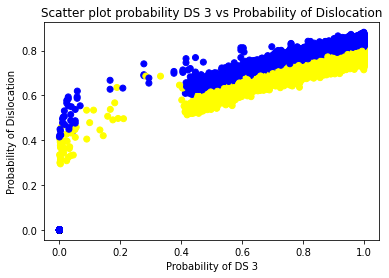

In [28]:
import matplotlib.pyplot as plt

# Scatter Plot
colors = {True:'red', False:'green'}
colors = {0 : 'blue', 1 : 'yellow'}
plt.scatter(popdis_highstd['DS_3'], 
            popdis_highstd['prdis'], 
            c=popdis_highstd['d_sf'].map(colors))
plt.title('Scatter plot probability DS 3 vs Probability of Dislocation')
plt.xlabel('Probability of DS 3')
plt.ylabel('Probability of Dislocation')
plt.show()

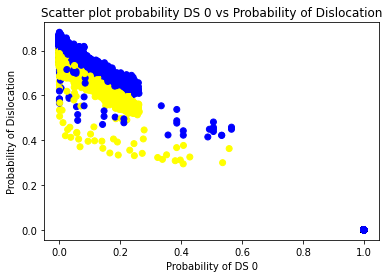

In [29]:
import matplotlib.pyplot as plt

# Scatter Plot
colors = {True:'red', False:'green'}
colors = {0 : 'blue', 1 : 'yellow'}
plt.scatter(popdis_highstd['DS_0'], 
            popdis_highstd['prdis'], 
            c=popdis_highstd['d_sf'].map(colors))
plt.title('Scatter plot probability DS 0 vs Probability of Dislocation')
plt.xlabel('Probability of DS 0')
plt.ylabel('Probability of Dislocation')
plt.show()

Dataset already exists locally. Reading from local cached zip.
Unzipped folder found in the local cache. Reading from it...


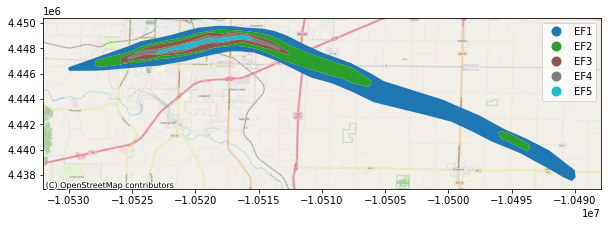

In [30]:
from pyincore_viz.geoutil import GeoUtil as viz
viz.plot_tornado(hazard_id, client, basemap=True)